In [1]:
import ast
from pathlib import Path

import geopandas as gpd
import pandas as pd
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import LineString
from shapely.geometry import Point
from osmnx.distance import great_circle_vec

In [2]:
pd.set_option("display.max_columns", None)
UBASEPATH = Path('/iarai/public/t4c/uber')


CITY = "berlin"

UFILE = 'movement-speeds-hourly-berlin-2019-2.parquet'
OBASEPATH = Path('/iarai/public/t4c/osm')
place = "germany-190101-truncated"

ONODESFILE = "%s_nodes.parquet" % place
OWAYSFILE = "%s_ways.parquet" % place

uspeeds_df = pd.read_parquet(UBASEPATH / UFILE)
uspeeds_df["osm_way_id"] = uspeeds_df["osm_way_id"].astype(str)
print(uspeeds_df.columns)


uspeeds_df

Index(['year', 'month', 'day', 'hour', 'utc_timestamp', 'segment_id',
       'start_junction_id', 'end_junction_id', 'osm_way_id',
       'osm_start_node_id', 'osm_end_node_id', 'speed_kph_mean',
       'speed_kph_stddev'],
      dtype='object')


,year,month,day,hour,utc_timestamp,segment_id,start_junction_id,end_junction_id,osm_way_id,osm_start_node_id,osm_end_node_id,speed_kph_mean,speed_kph_stddev
0,2019,2,15,8,2019-02-15T07:00:00.000Z,f50b8a5ca0afcdd31eb48403172284dbc42f2aeb,dc072f474bcbf30d75bd3b1e42974396af504bbb,32c9d31816ecf0fde2586bab37995d06ad5f6f3e,30709742,235637275,235637281,43.059,10.491
1,2019,2,15,20,2019-02-15T19:00:00.000Z,f50b8a5ca0afcdd31eb48403172284dbc42f2aeb,dc072f474bcbf30d75bd3b1e42974396af504bbb,32c9d31816ecf0fde2586bab37995d06ad5f6f3e,30709742,235637275,235637281,40.789,9.829
2,2019,2,25,9,2019-02-25T08:00:00.000Z,f50b8a5ca0afcdd31eb48403172284dbc42f2aeb,dc072f474bcbf30d75bd3b1e42974396af504bbb,32c9d31816ecf0fde2586bab37995d06ad5f6f3e,30709742,235637275,235637281,44.938,5.270
3,2019,2,15,9,2019-02-15T08:00:00.000Z,f50b8a5ca0afcdd31eb48403172284dbc42f2aeb,dc072f474bcbf30d75bd3b1e42974396af504bbb,32c9d31816ecf0fde2586bab37995d06ad5f6f3e,30709742,235637275,235637281,46.525,7.483
4,2019,2,15,14,2019-02-15T13:00:00.000Z,f50b8a5ca0afcdd31eb48403172284dbc42f2aeb,dc072f474bcbf30d75bd3b1e42974396af504bbb,32c9d31816ecf0fde2586bab37995d06ad5f6f3e,30709742,235637275,235637281,41.158,5.223
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1668433,2019,2,9,3,2019-02-09T02:00:00.000Z,ff8a397700e1b9293bad2c93cd1a03aedf5ae6f5,9a51ec7772c9bbf6375eeace41d2a4a62cca64e3,7205366afb085f05d29e3698481f57b08693cd30,4446505,1277848884,27306422,49.142,4.479
1668434,2019,2,9,0,2019-02-08T23:00:00.000Z,ff8a397700e1b9293bad2c93cd1a03aedf5ae6f5,9a51ec7772c9bbf6375eeace41d2a4a62cca64e3,7205366afb085f05d29e3698481f57b08693cd30,4446505,1277848884,27306422,50.208,9.834
1668435,2019,2,7,10,2019-02-07T09:00:00.000Z,096727bb10e8a3a8e2ddec40f6cef865d70fd09a,e8de6f3ca9b2ee93d65d2032f8fb273b8460b539,4abbcb68cb49784af136e89c0d6fbcf14796820b,4623430,29365140,29365090,33.913,4.781
1668436,2019,2,7,9,2019-02-07T08:00:00.000Z,096727bb10e8a3a8e2ddec40f6cef865d70fd09a,e8de6f3ca9b2ee93d65d2032f8fb273b8460b539,4abbcb68cb49784af136e89c0d6fbcf14796820b,4623430,29365140,29365090,34.595,4.885


In [3]:
#df_nodes_osm = pd.read_parquet(OBASEPATH / ONODESFILE)
df_nodes_osm = gpd.read_parquet(OBASEPATH / ONODESFILE)
print(df_nodes_osm.columns)
# print(df_nodes_osm.dtypes)
# print(df_nodes_osm)

Index(['osmid', 'y', 'x', 'version', 'timestamp', 'changeset', 'geometry'], dtype='object')


In [4]:
#df_ways_osm = pd.read_parquet(OBASEPATH / OWAYSFILE)
df_ways_osm = gpd.read_parquet(OBASEPATH / OWAYSFILE)
df_ways_osm["osmid"] = df_ways_osm["osmid"].astype(str)
df_ways_osm["refs"] = [ast.literal_eval(refs) if refs is not None and refs.startswith("[") else refs for refs in df_ways_osm["refs"]]
print(df_ways_osm.columns)

Index(['osmid', 'version', 'timestamp', 'changeset', 'highway', 'maxspeed',
       'name', 'refs', 'full_geometry', 'valid_geometry', 'geometry'],
      dtype='object')


In [5]:
assert type(df_ways_osm) == gpd.geodataframe.GeoDataFrame

In [6]:
assert uspeeds_df.groupby(
        ["osm_start_node_id", "osm_end_node_id", "osm_way_id", "year", "month", "day", "hour"]).count()[
        'speed_kph_mean'].max() == 1

In [7]:
uedges_df = uspeeds_df.groupby(["osm_start_node_id", "osm_end_node_id", "osm_way_id"]).first().reset_index()
uedges_df = uedges_df.drop(['year', 'month', 'day', 'hour', 'speed_kph_mean', 'speed_kph_stddev'], axis=1)
#print(uedges_df.columns)

uedges_df = df_ways_osm.merge(uedges_df,how='right', right_on="osm_way_id", left_on="osmid", suffixes=("_way", ""))\
    .merge(df_nodes_osm.add_suffix("_start_node"), how='left', left_on="osm_start_node_id", right_on="osmid_start_node")\
    .merge(df_nodes_osm.add_suffix("_end_node"), how='left', left_on="osm_end_node_id", right_on="osmid_end_node")
uedges_df

,osmid,version,timestamp,changeset,highway,maxspeed,name,refs,full_geometry,valid_geometry,geometry,osm_start_node_id,osm_end_node_id,osm_way_id,utc_timestamp,segment_id,start_junction_id,end_junction_id,osmid_start_node,y_start_node,x_start_node,version_start_node,timestamp_start_node,changeset_start_node,geometry_start_node,osmid_end_node,y_end_node,x_end_node,version_end_node,timestamp_end_node,changeset_end_node,geometry_end_node
0,24295532,10,2018-07-04T16:20:37Z,0,secondary,50,Emmentaler Straße,"[172546, 530313, 506769750, 530323, 29492995, ...",True,True,"LINESTRING (13.35225 52.56774, 13.35266 52.567...",172546,530313,24295532,2019-02-15T07:00:00.000Z,00c2608c6d47069e4615825d44916ad64c07757f,671ad16f6700420fa2f5a361d6ed4542e946c684,136ce91703e16b856b45cb1f5d1b01c8cf4e2e3c,172546.0,52.567738,13.352255,4,2010-05-03T16:15:50Z,0,POINT (13.35225 52.56774),5.303130e+05,52.567835,13.352664,7,2010-05-03T16:15:57Z,0,POINT (13.35266 52.56784)
1,160130963,19,2018-06-30T07:02:09Z,0,primary,50,Müllerstraße,"[602926407, 172558, 5729643858, 1282023416, 17...",True,True,"LINESTRING (13.33755 52.55868, 13.33737 52.558...",172558,172559,160130963,2019-02-15T09:00:00.000Z,21effb1a245d95d81ef27df3e1c2dbe55deb5a11,dfd87bcb0cf50487a326eb9d49e4e370c97bafc2,2d86d95c911447faf259712dd4ca482c988b0b23,172558.0,52.558781,13.337368,7,2017-08-30T07:36:19Z,0,POINT (13.33737 52.55878),1.725590e+05,52.559517,13.336074,5,2017-08-30T07:36:19Z,0,POINT (13.33607 52.55952)
2,160130963,19,2018-06-30T07:02:09Z,0,primary,50,Müllerstraße,"[602926407, 172558, 5729643858, 1282023416, 17...",True,True,"LINESTRING (13.33755 52.55868, 13.33737 52.558...",172559,29688040,160130963,2019-02-15T06:00:00.000Z,4e9739cb9bf1b0f82117f7848912878a3c7bc3c2,2d86d95c911447faf259712dd4ca482c988b0b23,554402f8a00c6d267ffcc01e2e64848477563316,172559.0,52.559517,13.336074,5,2017-08-30T07:36:19Z,0,POINT (13.33607 52.55952),2.968804e+07,52.560216,13.334868,6,2017-09-29T01:35:26Z,0,POINT (13.33487 52.56022)
3,4804203,11,2018-06-30T07:05:29Z,0,primary_link,50,,"[172562, 530351]",True,True,"LINESTRING (13.33066 52.56260, 13.33047 52.56253)",172562,530351,4804203,2019-02-27T08:00:00.000Z,fa6fa69117fc068654c68d8dc64d301ede4dc04d,001a7d3ea3e0d84f604b27c0240e144e72716a93,d8ce1bc2acb9dac32c722548e7c477fd84e3af73,172562.0,52.562600,13.330664,8,2014-04-09T12:16:41Z,0,POINT (13.33066 52.56260),5.303510e+05,52.562532,13.330466,8,2014-04-09T12:16:41Z,0,POINT (13.33047 52.56253)
4,28427149,16,2018-06-30T07:05:29Z,0,secondary,50,Scharnweberstraße,"[172562, 5729649488, 223986414, 1350487142, 29...",True,True,"LINESTRING (13.33066 52.56260, 13.33048 52.562...",172562,6313308067,28427149,2019-02-15T01:00:00.000Z,79f9063bd7f90e125b0b2cc8169717a0e11e1181,001a7d3ea3e0d84f604b27c0240e144e72716a93,bca7d505b78ca24c817ef3a40c5e3f0d6fa24eee,172562.0,52.562600,13.330664,8,2014-04-09T12:16:41Z,0,POINT (13.33066 52.56260),NaN,NaN,NaN,NaN,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16874,41927333,11,2017-04-18T16:22:56Z,0,secondary,50,Brunnenstraße,"[21441737, 3918673862, 2914606229, 310351081, ...",True,True,"LINESTRING (13.39889 52.53260, 13.39874 52.533...",6565966757,21441737,41927333,2019-02-24T17:00:00.000Z,06ce743e958c5dcb6e37762e6ed5d711363833fd,58fce0fcc779f5f5fb9fc84947cb3b0dd0c5ee95,e8c26919e95c74bb785e935feee255e11a17a451,NaN,NaN,NaN,NaN,NaN,NaN,None,2.144174e+07,52.532600,13.398889,9,2014-11-13T19:42:18Z,0,POINT (13.39889 52.53260)
16875,41927333,11,2017-04-18T16:22:56Z,0,secondary,50,Brunnenstraße,"[21441737, 3918673862, 2914606229, 310351081, ...",True,True,"LINESTRING (13.39889 52.53260, 13.39874 52.533...",6565966757,26752062,41927333,2019-02-09T19:00:00.000Z,ce2a75385d1b515356dc2176bcc1c867f6b64bf3,58fce0fcc779f5f5fb9fc84947cb3b0dd0c5ee95,a7f66227b7e44d27885be2423ea829f800d88afe,NaN,NaN,NaN,NaN,NaN,NaN,None,2.675206e+07,52.534946,13.398028,5,2016-03-30T17:54:15Z,0,POINT (13.39803 52.53495)
16876,459

In [8]:
uedges_df["length_meters"] = [great_circle_vec(x_u,y_u,x_v,y_v)  for x_u,y_u,x_v,y_v in zip(uedges_df["x_start_node"],uedges_df["y_start_node"],uedges_df["x_end_node"],uedges_df["y_end_node"])]

In [9]:
uedges_df["geometry_old"]=uedges_df["geometry"]

In [10]:
uedges_df.columns

Index(['osmid', 'version', 'timestamp', 'changeset', 'highway', 'maxspeed',
       'name', 'refs', 'full_geometry', 'valid_geometry', 'geometry',
       'osm_start_node_id', 'osm_end_node_id', 'osm_way_id', 'utc_timestamp',
       'segment_id', 'start_junction_id', 'end_junction_id',
       'osmid_start_node', 'y_start_node', 'x_start_node',
       'version_start_node', 'timestamp_start_node', 'changeset_start_node',
       'geometry_start_node', 'osmid_end_node', 'y_end_node', 'x_end_node',
       'version_end_node', 'timestamp_end_node', 'changeset_end_node',
       'geometry_end_node', 'length_meters', 'geometry_old'],
      dtype='object')

In [11]:
# check it's a geopandas frame
assert type(uedges_df) == gpd.geodataframe.GeoDataFrame

In [12]:
# print(df_ways_osm)
# print(uspeeds_df.columns)
# print(uspeeds_df.dtypes)
#uspeeds_df = uspeeds_df.merge(df_nodes_osm, how='left', left_on="osm_start_node_id", right_on="osmid",
#                              suffixes=("", "_start_node")) \
#    .merge(df_nodes_osm, how='left', left_on="osm_end_node_id", right_on="osmid",
#           suffixes=("_start_node", "_end_node")) \
#     .merge(df_ways_osm, how='left', left_on="osm_way_id", right_on="osmid", suffixes=("", "_way"))
#print(uspeeds_df.columns)
#print(uedges_df.columns)

In [13]:
uedges_df.groupby("highway").agg(count=("osm_start_node_id", "count"), length_meters_mean=("length_meters","mean"))

,count,length_meters_mean
highway,,
construction,8,36.719721
living_street,95,109.234316
motorway,517,269.947794
motorway_link,385,144.362906
primary,2970,105.182296
primary_link,15,36.327633
residential,3023,101.070265
secondary,6631,91.476556
secondary_link,21,50.739361


### Sanity check node degrees Uber

In [14]:
neighbors = defaultdict(lambda: set())
for u,v in zip(uedges_df["osm_start_node_id"],uedges_df["osm_end_node_id"]):
    neighbors[u].add(v)
    neighbors[v].add(u)

In [15]:
node_degrees = {u:len(n) for u,n in neighbors.items()}
node_degrees

{172546: 2,
 530313: 2,
 172558: 2,
 172559: 2,
 29688040: 2,
 172562: 3,
 530351: 4,
 6313308067: 2,
 172564: 4,
 530185: 2,
 21509247: 2,
 172566: 2,
 3722686925: 2,
 172587: 2,
 29493004: 2,
 172589: 2,
 665285019: 2,
 172594: 2,
 21441701: 2,
 458324: 2,
 458329: 2,
 4555499795: 2,
 458330: 3,
 458334: 3,
 26708458: 4,
 458333: 2,
 458336: 2,
 458337: 2,
 458338: 2,
 1020330221: 2,
 458345: 2,
 267209693: 2,
 458350: 3,
 107298813: 2,
 267182060: 2,
 458352: 2,
 26750509: 2,
 458356: 2,
 268084036: 2,
 458362: 3,
 458364: 2,
 458365: 3,
 268111109: 2,
 268113574: 2,
 484074: 2,
 27007803: 2,
 484075: 2,
 1940005197: 2,
 484078: 4,
 130088130: 1,
 267399134: 3,
 484082: 2,
 4584515687: 3,
 484090: 2,
 484095: 2,
 484096: 2,
 4562390877: 2,
 484102: 3,
 27216277: 3,
 484107: 3,
 4285890874: 2,
 484110: 3,
 26662459: 3,
 487673623: 3,
 484115: 2,
 6561995746: 2,
 484119: 3,
 267398957: 3,
 484121: 4,
 27007781: 2,
 270596255: 2,
 484128: 2,
 267380414: 2,
 484258: 1,
 484269: 2,
 4842

In [16]:
counts, bins = np.histogram(list(node_degrees.values()), bins=range(10))
for lb,c in zip(bins,counts):
    print(f"{lb}: {c:10d} ({c/len(node_degrees)*100:5.2f}%)")

0:          0 ( 0.00%)
1:        644 ( 4.98%)
2:      10125 (78.35%)
3:       1216 ( 9.41%)
4:        917 ( 7.10%)
5:         20 ( 0.15%)
6:          1 ( 0.01%)
7:          0 ( 0.00%)
8:          0 ( 0.00%)


(array([0.0000e+00, 6.4400e+02, 1.0125e+04, 1.2160e+03, 9.1700e+02,
        2.0000e+01, 1.0000e+00, 0.0000e+00, 0.0000e+00]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <BarContainer object of 9 artists>)

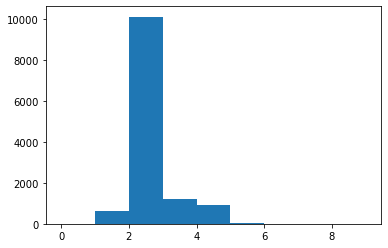

In [17]:
plt.hist(list(node_degrees.values()), bins=range(10))

Most have degree 2, some have 3 and very few have 1 and 4. Looks plausible.

### How many Uber nodes and ways can we match with historic OSM?

In [18]:
unodes = set(uedges_df["osm_start_node_id"]).union(uedges_df["osm_end_node_id"])
uways = set(uedges_df["osm_way_id"])
onodes= set(df_nodes_osm["osmid"])
oways=set(df_ways_osm["osmid"])

In [19]:
uo_nodes = unodes.intersection(onodes)

In [20]:
len(uo_nodes)/len(unodes), len(unodes)-len(uo_nodes), len(uo_nodes), len(unodes)

(0.9852201501199412, 191, 12732, 12923)

In [21]:
uo_ways = uways.intersection(oways)

In [22]:
len(uo_ways)/len(uways), len(uways)-len(uo_ways), len(uo_ways), len(uways)

(0.9852411388727484, 127, 8478, 8605)

### extract geometry for Uber road (create road_graph_nodes.parquet and road_graph_edges.parquet) for Uber road graph

In [23]:
ambiguous = []
projected_geometries = []
status = []
for x_start_node,y_start_node,x_end_node,y_end_node,geometry,osm_way_id,hw,refs,osm_start_node_id,osm_end_node_id in zip(uedges_df["x_start_node"],uedges_df["y_start_node"],uedges_df["x_end_node"],uedges_df["y_end_node"],uedges_df["geometry_old"], uedges_df["osm_way_id"], uedges_df["highway"],uedges_df["refs"], uedges_df["osm_start_node_id"], uedges_df["osm_end_node_id"]):
#     print(x_start_node,y_start_node,x_end_node,y_end_node)
#     print(osm_way_id)
#     print(hw)
    
    # 
    if geometry is None:

        if hw is None:
            assert osm_way_id in uways
            assert osm_way_id not in oways
            status.append("no highway")
        else:
            status.append("no geometry")
        projected_geometries.append(None)
        continue
    coords = list(geometry.coords)
#     print(list(geometry.coords))    
#     assert len(set(geometry.coords))==len(list(geometry.coords)), (osm_way_id,len(set(geometry.coords)),len(list(geometry.coords)))
    
#     start_node_index = [i for i, coord in enumerate(coords) if coord==(x_start_node,y_start_node)]
    start_node_index = [i for i, ref in enumerate(refs) if ref ==osm_start_node_id ]
    if len(start_node_index) != 1:
#         print(x_start_node,y_start_node,x_end_node,y_end_node)
#         print(osm_start_node_id)
#         print(osm_end_node_id)
#         print(osm_way_id)
#         print(refs)
#         raise
        ambiguous.append(osm_way_id)
        projected_geometries.append(None)
        status.append("start node ambiguous")
#         print(x_start_node,y_start_node,x_end_node,y_end_node,geometry,osm_way_id,hw)
        continue
    start_node_index=start_node_index[0]
#     print(start_node_index)
    
#     end_node_index = [i for i, coord in enumerate(coords) if coord==(x_end_node,y_end_node)]
    end_node_index = [i for i, ref in enumerate(refs) if ref ==osm_end_node_id]
    
    if len(end_node_index) != 1:
        ambiguous.append(osm_way_id)
        projected_geometries.append(None)
        status.append("end node ambiguous")
#         print(x_start_node,y_start_node,x_end_node,y_end_node,geometry,osm_way_id,hw)
        continue
    end_node_index=end_node_index[0]
#     print(end_node_index)
    assert (start_node_index < end_node_index) or  (start_node_index > end_node_index) , (start_node_index ,end_node_index)
#     geometry = LineString(coords[start_node_index:end_node_index+1])
#     print(coords)
#     print(coords[4:2])
# #     break
#     break

    if start_node_index < end_node_index:
        projected_geometries.append(LineString(coords[start_node_index:end_node_index+1]))
    elif start_node_index > end_node_index:
        projected_geometries.append(LineString(reversed(coords[end_node_index:start_node_index+1])))
    else:
        raise
    status.append("ok")
    if len(projected_geometries[-1].coords)==0:
        print(start_node_index,end_node_index)
        print((x_start_node,y_start_node,x_end_node,y_end_node,geometry,osm_way_id,hw,refs,osm_start_node_id,osm_end_node_id))
        raise
uedges_df["geometry"] = projected_geometries
uedges_df["status"]=status        

In [24]:
# TODO visual inspection!
# TODO can improve on the ambiguous?
matching_stats_df = uedges_df.groupby(["highway","status"]).agg(count=("osmid","count"), avg_length_meters=("length_meters", "mean"))
matching_stats_df["percentage"] = matching_stats_df["count"]/len(uedges_df)*100
matching_stats_df = matching_stats_df.reset_index()
matching_stats_df

,highway,status,count,avg_length_meters,percentage
0,construction,end node ambiguous,3,NaN,0.017774
1,construction,ok,2,36.719721,0.011849
2,construction,start node ambiguous,3,NaN,0.017774
3,living_street,end node ambiguous,2,11.785435,0.011849
4,living_street,ok,91,111.376050,0.539131
5,living_street,start node ambiguous,2,11.785435,0.011849
6,motorway,end node ambiguous,1,NaN,0.005925
7,motorway,ok,515,269.542609,3.051129
8,motorway,start node ambiguous,1,478.617899,0.005925
9,motorway_link,end node ambiguous,1,300.996341,0.005925


In [25]:
len(~uedges_df["geometry"].isnull())

16879

In [26]:
uedges_df[uedges_df["geometry"].isnull()].groupby("highway").agg(count=("osmid","count"), avg_length_meters=("length_meters", "mean"), med_length_meters=("length_meters", "median"), status=("status", set))

,count,avg_length_meters,med_length_meters,status
highway,,,,
construction,6,NaN,NaN,"{end node ambiguous, start node ambiguous}"
living_street,4,11.785435,11.785435,"{end node ambiguous, start node ambiguous}"
motorway,2,478.617899,478.617899,"{end node ambiguous, start node ambiguous}"
motorway_link,1,300.996341,300.996341,{end node ambiguous}
primary,33,53.812208,35.730537,"{end node ambiguous, start node ambiguous}"
residential,89,58.647456,17.135983,"{end node ambiguous, start node ambiguous}"
secondary,167,112.745306,44.070519,"{end node ambiguous, start node ambiguous}"
tertiary,91,93.206768,68.722249,"{end node ambiguous, start node ambiguous}"
unclassified,4,163.144529,163.144529,"{end node ambiguous, start node ambiguous}"


In [27]:
uedges_df[(uedges_df["geometry"].isnull())&(uedges_df["highway"]=="motorway")]

# refs [311070, 3744469281] 
# https://www.openstreetmap.org/way/345803322#map=17/51.25284/-0.12408
# https://www.openstreetmap.org/node/202995#map=16/51.2518/-0.1270       -> probably just deleted between recording and OSM version
# https://www.openstreetmap.org/node/3744469281#map=19/51.25548/-0.12439 -> in OSM
# here we could fix if the missing one has just one outgoing edge.


,osmid,version,timestamp,changeset,highway,maxspeed,name,refs,full_geometry,valid_geometry,geometry,osm_start_node_id,osm_end_node_id,osm_way_id,utc_timestamp,segment_id,start_junction_id,end_junction_id,osmid_start_node,y_start_node,x_start_node,version_start_node,timestamp_start_node,changeset_start_node,geometry_start_node,osmid_end_node,y_end_node,x_end_node,version_end_node,timestamp_end_node,changeset_end_node,geometry_end_node,length_meters,geometry_old,status
41,4484056,9,2013-09-19T16:49:21Z,0,motorway,80,Hinckeldeybrücke,"[484115, 27009012]",True,True,None,484115,6561995746,4484056,2019-02-05T16:00:00.000Z,2fdf9489191dd89e01d5e7ef804e59783d18485c,6c955a105eab088266669a2d5f4ba0857d4b6b93,4e7e8d6c2e272921864b4037cc778d85d5c070fa,484115.0,52.548754,13.301041,9,2016-06-22T15:52:28Z,0,POINT (13.30104 52.54875),NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,"LINESTRING (13.30104 52.54875, 13.30028 52.54782)",end node ambiguous
7881,215668775,4,2017-06-08T14:53:26Z,0,motorway,50,,"[21508807, 267428760, 267428761, 267428444, 26...",True,True,None,267428802,267428207,215668775,2019-02-15T10:00:00.000Z,54dc1db68d856f75c87d3616ecdbe0510009d94f,fba4d718862163670ae814de2452a677ba3008b7,92199e2c43dab66f67725daaf741163b133e6a3c,267428802.0,52.567804,13.306127,7,2013-04-06T01:09:01Z,0,POINT (13.30613 52.56780),267428207.0,52.565203,13.309608,3,2015-01-25T01:39:54Z,0,POINT (13.30961 52.56520),478.617899,"LINESTRING (13.30620 52.56763, 13.30640 52.567...",start node ambiguous


In [28]:
uedges_debug_gdf = gpd.GeoDataFrame.from_records([{"name":name, "geometry": LineString(geometry.coords)} for name,geometry,status in zip(uedges_df["name"],uedges_df["geometry_old"],uedges_df["status"]) if geometry is not None and "ambiguous" in status])
uedges_debug_gdf

,name,geometry
0,Scharnweberstraße,"LINESTRING (13.33066 52.56260, 13.33048 52.562..."
1,Hinckeldeybrücke,"LINESTRING (13.30104 52.54875, 13.30028 52.54782)"
2,Neue Bahnhofstraße,"LINESTRING (13.47029 52.50619, 13.47040 52.506..."
3,Boxhagener Straße,"LINESTRING (13.47029 52.50619, 13.47016 52.506..."
4,Kastanienallee,"LINESTRING (13.40625 52.53520, 13.40515 52.53400)"
...,...,...
392,Kastanienallee,"LINESTRING (13.41142 52.54019, 13.41073 52.539..."
393,Brunnenstraße,"LINESTRING (13.39889 52.53260, 13.39874 52.533..."
394,Brunnenstraße,"LINESTRING (13.39889 52.53260, 13.39874 52.533..."
395,Bayreuther Straße,"LINESTRING (13.34432 52.50427, 13.34430 52.503..."


In [29]:
uedges_debug_gdf.to_parquet(f"{CITY}_road_graph_edges_debug.parquet")

In [30]:
uedges_debug_gdf.to_file(f"{CITY}_road_graph_edges_debug.gpkg", driver="GPKG", layer="edges")

## Add speed_kph

In [31]:
edges = uedges_df

# Logic taken from
# https://github.com/gboeing/osmnx/blob/ad54852a3131800b1eedeb167eccaa0276abd998/osmnx/speed.py

from osmnx.speed import _collapse_multiple_maxspeed_values, _clean_maxspeed


hwy_speeds=None
fallback=np.nan
precision=1
agg=np.mean

# collapse any highway lists (can happen during graph simplification)
# into string values simply by keeping just the first element of the list
edges["highway"] = edges["highway"].map(lambda x: x[0] if isinstance(x, list) else x)

if "maxspeed" in edges.columns:
    # collapse any maxspeed lists (can happen during graph simplification)
    # into a single value
    edges["maxspeed"] = edges["maxspeed"].apply(_collapse_multiple_maxspeed_values, agg=agg)

    # create speed_kph by cleaning maxspeed strings and converting mph to
    # kph if necessary
    edges["speed_kph"] = edges["maxspeed"].astype(str).map(_clean_maxspeed).astype(float)
else:
    # if no edges in graph had a maxspeed attribute
    edges["speed_kph"] = None

# if user provided hwy_speeds, use them as default values, otherwise
# initialize an empty series to populate with values
if hwy_speeds is None:
    hwy_speed_avg = pd.Series(dtype=float)
else:
    hwy_speed_avg = pd.Series(hwy_speeds).dropna()

# for each highway type that caller did not provide in hwy_speeds, impute
# speed of type by taking the mean of the preexisting speed values of that
# highway type
for hwy, group in edges.groupby("highway"):
    if hwy not in hwy_speed_avg:
        hwy_speed_avg.loc[hwy] = agg(group["speed_kph"])

# if any highway types had no preexisting speed values, impute their speed
# with fallback value provided by caller. if fallback=np.nan, impute speed
# as the mean speed of all highway types that did have preexisting values
hwy_speed_avg = hwy_speed_avg.fillna(fallback).fillna(agg(hwy_speed_avg))

# for each edge missing speed data, assign it the imputed value for its
# highway type
speed_kph = (
    edges[["highway", "speed_kph"]].set_index("highway").iloc[:, 0].fillna(hwy_speed_avg)
)

# all speeds will be null if edges had no preexisting maxspeed data and
# caller did not pass in hwy_speeds or fallback arguments
if pd.isnull(speed_kph).all():
    raise ValueError(
        (
            "this graph's edges have no preexisting `maxspeed` "
            "attribute values so you must pass `hwy_speeds` or "
            "`fallback` arguments."
        )
    )

# add speed kph attribute to graph edges
edges["speed_kph"] = speed_kph.round(precision).values

## Output road_graph_nodes.parquet and road_graph_edges.parquet in compliant format

In [32]:
# edges_attributes_list = ["u", "v", "osmid", "speed_kph", "maxspeed", "highway", "oneway", "lanes", "tunnel", "length_meters", "geometry"]
# [["node_id", "x", "y"]]

In [33]:
for u,v,osmid,highway,length_meters,geometry,status in zip(
        uedges_df["osm_start_node_id"],
        uedges_df["osm_end_node_id"],
        uedges_df["osm_way_id"],
        uedges_df["highway"],
        uedges_df["length_meters"],
        uedges_df["geometry"],
        uedges_df["status"]
    ):
    if status=="ok" and len(geometry.coords)==0:
        print((u,v,osmid,highway,length_meters,geometry,status))
        break

In [34]:
uedges_gdf = gpd.GeoDataFrame.from_records([{
    "gkey": f"{u}_{v}_{osmid}", # TODO hacky
    "u":u, 
    "v":v, 
    "osmid":osmid, 
    "speed_kph": speed_kph, 
    "maxspeed": maxspeed, 
    "highway":highway, 
    "oneway":"", # TODO
    "lanes":"", # TODO
    "tunnel":"", # TODO
    "length_meters":length_meters, 
    "geometry": LineString(geometry.coords),
    "name": name # TODO in addition to data_pipeline - add there as well?
} 
    for u,v,osmid,speed_kph,maxspeed,highway,length_meters,geometry,status,name in zip(
        uedges_df["osm_start_node_id"],
        uedges_df["osm_end_node_id"],
        uedges_df["osm_way_id"],
        uedges_df["speed_kph"],
        uedges_df["maxspeed"],
        uedges_df["highway"],
        uedges_df["length_meters"],
        uedges_df["geometry"],
        uedges_df["status"],
        uedges_df["name"],
    ) if status=="ok"])
uedges_gdf

,gkey,u,v,osmid,speed_kph,maxspeed,highway,oneway,lanes,tunnel,length_meters,geometry,name
0,172546_530313_24295532,172546,530313,24295532,50.0,50,secondary,,,,46.759468,"LINESTRING (13.35225 52.56774, 13.35266 52.56784)",Emmentaler Straße
1,172558_172559_160130963,172558,172559,160130963,50.0,50,primary,,,,164.463017,"LINESTRING (13.33737 52.55878, 13.33725 52.558...",Müllerstraße
2,172559_29688040_160130963,172559,29688040,160130963,50.0,50,primary,,,,153.966487,"LINESTRING (13.33607 52.55952, 13.33578 52.559...",Müllerstraße
3,172562_530351_4804203,172562,530351,4804203,50.0,50,primary_link,,,,23.283372,"LINESTRING (13.33066 52.56260, 13.33047 52.56253)",
4,172564_530185_4432669,172564,530185,4432669,50.0,50,secondary,,,,44.345716,"LINESTRING (13.32771 52.56405, 13.32759 52.563...",Kurt-Schumacher-Platz
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16274,6171409045_6171409044_71143837,6171409045,6171409044,71143837,50.0,50,secondary,,,,71.576136,"LINESTRING (13.39911 52.50819, 13.39949 52.50873)",Axel-Springer-Straße
16275,6172685050_26745400_417807344,6172685050,26745400,417807344,50.0,50,residential,,,,5.821343,"LINESTRING (13.36256 52.50585, 13.36258 52.50590)",Bendlerbrücke
16276,6172693100_26746095_16943617,6172693100,26746095,16943617,30.0,30,primary,,,,9.151821,"LINESTRING (13.36812 52.50590, 13.36809 52.50582)",Potsdamer Straße
16277,6173378369_426425009_132105452,6173378369,426425009,132105452,50.0,50,tertiary,,,,3.764184,"LINESTRING (13.49198 52.50117, 13.49202 52.50116)",Lückstraße


In [35]:
uedges_gdf.dtypes

gkey               object
u                   int64
v                   int64
osmid              object
speed_kph         float64
maxspeed           object
highway            object
oneway             object
lanes              object
tunnel             object
length_meters     float64
geometry         geometry
name               object
dtype: object

In [36]:
assert type(uedges_gdf) == gpd.geodataframe.GeoDataFrame

In [37]:
# TODO naming as "london/road_graph_edges.parquet"
uedges_gdf.to_parquet(f"{CITY}_road_graph_edges.parquet")

In [38]:
uedges_gdf.to_file(f"{CITY}_road_graph_edges.gpkg", driver="GPKG", layer="edges")

In [39]:
nodes_in_uedges_gdf = set(uedges_gdf["u"]).union(uedges_gdf["v"])
nodes_in_uedges_gdf

{262471682,
 974880771,
 604995590,
 682328071,
 501547016,
 3491168274,
 30736405,
 5222793245,
 321323040,
 321323043,
 321323051,
 564690992,
 603619377,
 682328112,
 603619379,
 974880819,
 107315253,
 27492414,
 26738752,
 472711238,
 5741674568,
 2121597004,
 26935373,
 1824063565,
 2125135958,
 26738778,
 295600226,
 3836936295,
 697335915,
 3836936301,
 27787375,
 3836936303,
 1208647794,
 558563443,
 1552842866,
 27787388,
 27787392,
 27459716,
 1552842884,
 1895989383,
 2071462025,
 100532362,
 30507148,
 1967685773,
 27459728,
 2922414225,
 1876099221,
 280985752,
 1552842916,
 702382249,
 1964736682,
 2245787825,
 287932598,
 1211695289,
 4181885114,
 4181885118,
 4181885125,
 4181885127,
 4181885132,
 5190910158,
 5190910159,
 31260881,
 1475313873,
 4181885139,
 31260887,
 4181885143,
 305234138,
 319717595,
 1122074843,
 29720800,
 124322017,
 1020330210,
 1475313891,
 5893554405,
 29688040,
 101220587,
 4892262636,
 1020330221,
 5386666221,
 29950195,
 31260916,
 297208

In [40]:
unodes_gdf = gpd.GeoDataFrame.from_records([{
    "node_id":node_id, 
    "x":x, 
    "y":y,
    "geometry": geometry} 
    for node_id,x,y,geometry in zip(
        df_nodes_osm["osmid"],
        df_nodes_osm["x"],
        df_nodes_osm["y"],
        df_nodes_osm["geometry"]
    )
    if node_id in nodes_in_uedges_gdf
])
unodes_gdf

,node_id,x,y,geometry
0,172546,13.352255,52.567738,POINT (13.35225 52.56774)
1,172558,13.337368,52.558781,POINT (13.33737 52.55878)
2,172559,13.336074,52.559517,POINT (13.33607 52.55952)
3,172562,13.330664,52.562600,POINT (13.33066 52.56260)
4,172564,13.327708,52.564046,POINT (13.32771 52.56405)
...,...,...,...,...
12650,6171409045,13.399112,52.508193,POINT (13.39911 52.50819)
12651,6172685050,13.362564,52.505849,POINT (13.36256 52.50585)
12652,6172693100,13.368124,52.505898,POINT (13.36812 52.50590)
12653,6173378369,13.491984,52.501171,POINT (13.49198 52.50117)


In [41]:
unodes_gdf.to_parquet(f"{CITY}_road_graph_nodes.parquet")

In [42]:
unodes_gdf.to_file(f"{CITY}_road_graph_nodes.gpkg", driver="GPKG", layer="nodes")

In [43]:
assert len(uedges_gdf) == matching_stats_df[matching_stats_df["status"]=="ok"]["count"].sum()